# Air Quality Index FORECASTING on Beijing air quality data

## We will try to make a 1 day forecast (24 timesteps) based on 7 past days data (168 timesteps)
## We will use air quality features as X and target column (AQI index) as y
## Let's prepare functions for manualy calculating AQI based on provided air information

# Air Quality Index Forecasting on Beijing Air Quality Data

In this Jupyter Notebook, we will create a forecast for the Air Quality Index (AQI) in Beijing. Our goal is to predict the AQI for the next day (24 timesteps) based on the air quality features from the past 7 days (168 timesteps). We will use a set of functions to manually calculate the AQI based on the provided air quality information.

## Forecasting Approach

We will follow these steps to create the AQI forecast:

1. Data Preprocessing: We will preprocess the air quality datasets from different Beijing stations, calculate sub-index values for each pollutant, and create the AQI target column.

2. Sequence Generation: We will create sequences of input data (X) and target values (y) for each station. Each X sequence will contain 168 hourly timesteps (7 days), and each y sequence will contain 24 hourly timesteps (1 day).

3. Model Selection: We will use a double-layered LSTM (Long Short-Term Memory) model, which is well-suited for time series forecasting tasks.

4. Model Training: We will train the LSTM model on the data from one station while using data from another station for validation.

5. Model Evaluation: We will evaluate the trained model's performance using metrics such as Mean Squared Error (MSE) and R-squared (R2) score.

6. Forecasting: We will generate AQI forecasts for a specific date for all stations using the trained model.

## AQI Calculation Functions

We have defined functions for manually calculating the sub-indices and AQI based on pollutant concentrations. These functions are used to preprocess the data and generate the target AQI values.

Let's begin by implementing these steps and creating the AQI forecasts for the specified date.

# Defining functions for calculating Air Quality Index

In [1]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

def get_category_upper_limit(category):
    if category == 'Good':
        return 50
    elif category == 'Satisfactory':
        return 100
    elif category == 'Moderate':
        return 200
    elif category == 'Poor':
        return 300
    elif category == 'Very Poor':
        return 400
    elif category == 'Severe':
        return np.inf
    else:
        return np.nan

# Preprocessing Beijing Air Quality Datasets

In this section, we will preprocess 12 datasets from different Beijing stations. The preprocessing steps include calculating subindexes, creating a datetime column, dropping unnecessary columns, filling NaN values, and more. The preprocessed data will be saved for future analysis.

## Preprocessing Code

Here's the Python code that performs the preprocessing:

In [2]:
import os
import pandas as pd
import numpy as np
import glob

# Define functions for calculating subindexes (get_PM25_subindex, get_PM10_subindex, etc.)
def preprocess_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert columns to datetime and set 'date' as the index
    df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df.set_index('date', inplace=True)
    
    # Drop unnecessary columns
    df.drop(['No', 'year', 'month', 'day', 'hour', 'station', 'TEMP', 'PRES', 'DEWP', 'RAIN',	'wd', 'WSPM'], axis=1, inplace=True)
    
    # Convert 'CO' column values from mg/m³ to g/m³
    df['CO'] = df['CO'] / 1000

    # Replace NaN values with the median value of each column
    df = df.bfill()
    
    # Calculate subindexes and AQI
    df["PM2.5_SubIndex"] = df["PM2.5"].apply(lambda x: get_PM25_subindex(x))
    df["PM10_SubIndex"] = df["PM10"].apply(lambda x: get_PM10_subindex(x))
    df["SO2_SubIndex"] = df["SO2"].apply(lambda x: get_SO2_subindex(x))
    df["CO_SubIndex"] = df["CO"].apply(lambda x: get_CO_subindex(x))
    df["O3_SubIndex"] = df["O3"].apply(lambda x: get_O3_subindex(x))
    df["AQI_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
    df['AQI'] = df['AQI_calculated']
    df = df.drop(['AQI_calculated', 'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex','CO_SubIndex', 'O3_SubIndex'], axis=1)
    
    return df

# Get a list of CSV files
csv_files = glob.glob('Beijing/*.csv')

# Create the 'Preprocessed' directory if it doesn't exist
os.makedirs('Preprocessed', exist_ok=True)

# Loop through each CSV file and preprocess
for file_path in csv_files:
    df_preprocessed = preprocess_csv(file_path)
    
    # Extract the station name from the file name
    file_name = file_path.split('/')[-1].split('.')[0]
    station_name = file_name.split('_')[2]  # Extract the station name part
    
    # Save the preprocessed DataFrame to a new CSV file
    preprocessed_file_path = f'Preprocessed/{station_name}_preprocessed.csv'
    df_preprocessed.to_csv(preprocessed_file_path)

    print(f"Preprocessing complete for '{file_name}' and saved to '{preprocessed_file_path}'.")


Preprocessing complete for 'PRSA_Data_Gucheng_20130301-20170228' and saved to 'Preprocessed/Gucheng_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Huairou_20130301-20170228' and saved to 'Preprocessed/Huairou_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Tiantan_20130301-20170228' and saved to 'Preprocessed/Tiantan_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Changping_20130301-20170228' and saved to 'Preprocessed/Changping_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Guanyuan_20130301-20170228' and saved to 'Preprocessed/Guanyuan_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Nongzhanguan_20130301-20170228' and saved to 'Preprocessed/Nongzhanguan_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Wanliu_20130301-20170228' and saved to 'Preprocessed/Wanliu_preprocessed.csv'.
Preprocessing complete for 'PRSA_Data_Dongsi_20130301-20170228' and saved to 'Preprocessed/Dongsi_preprocessed.csv'.
Preprocessing complete for 'PRSA_Dat

# Checking the Sample Preprocessed Dataset - Gucheng Station

In this section, we will check the sample preprocessed dataset for the Gucheng station. We will examine missing values and display information about the dataset.

## Checking Code

Here's the Python code that checks the sample preprocessed dataset:

In [3]:
import pandas as pd

# Read the preprocessed CSV file for Gucheng station
df_random = pd.read_csv("Preprocessed/Gucheng_preprocessed.csv", index_col='date')

# Check for missing values
missing_values = df_random.isna().sum()

# Display dataset information
df_random.info()

print("Missing Values:")
print(missing_values)


<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   35064 non-null  float64
 1   PM10    35064 non-null  float64
 2   SO2     35064 non-null  float64
 3   NO2     35064 non-null  float64
 4   CO      35064 non-null  float64
 5   O3      35064 non-null  float64
 6   AQI     35064 non-null  float64
dtypes: float64(7)
memory usage: 2.1+ MB
Missing Values:
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
AQI      0
dtype: int64


# Scaling and Rearranging Data into Sequences

In this section, we will preprocess the scaled data and rearrange it into sequences for each station. The goal is to create input-output pairs that the machine learning model can learn from. Each input sequence (X) will contain data from the past 7 days (168 hourly timesteps), and each target sequence (y) will contain data for the next 24 hours (1 day).

## Sequence Creation Process

1. **Interpolation and Normalization**: Before creating sequences, the data undergoes two preprocessing steps. First, missing values are imputed using linear interpolation. This ensures that the data is continuous and suitable for time-series analysis. Then, the data is normalized using the MinMaxScaler. Normalization scales the data between 0 and 1, which can improve the model's training stability and convergence.

2. **Input and Output Columns**: We define a set of input columns (features) that we believe are relevant for predicting the target column (AQI). These columns include 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', and 'O3'. The output column is 'AQI'.

3. **Creating Sequences**: For each station, we iterate through the preprocessed data. Starting from the beginning, we slide a window of 7 days (168 timesteps) to form an input sequence (X). Immediately following the input sequence, the next 24 hours (1 day) of data are selected to form the corresponding target sequence (y). This process is repeated with a step size of 24 hours, effectively creating pairs of X and y sequences.

4. **Storing Sequences**: The resulting sequences for each station are stored in a dictionary. The keys of the dictionary follow the format 'X_stationname' for input sequences and 'y_stationname' for output sequences.

By structuring the data into sequences, we enable the model to learn temporal patterns and dependencies. The input sequences capture the station's historical air quality conditions, while the corresponding output sequences represent the future AQI values that the model will learn to predict.

## Sequence Creation Code

Below is the Python code that performs data scaling and sequence creation:

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to create sequences
def create_sequences(df, input_columns, output_column, input_sequence_length, output_sequence_length):
    # Impute NaN values using linear interpolation
    df = df.interpolate(method='linear', axis=0)
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)
    
    # Extract scaled_x and scaled_y
    scaled_x = data_scaled[:, df.columns.isin(input_columns)]
    scaled_y = data_scaled[:, df.columns.get_loc(output_column)]
    
    # Lists to store input sequences (X) and output sequences (y)
    X_sequences = []
    y_sequences = []
    
    # Create sequences
    for i in range(0, len(scaled_x) - input_sequence_length - output_sequence_length + 1, output_sequence_length):
        X_sequences.append(scaled_x[i : i + input_sequence_length])
        y_sequences.append(scaled_y[i + input_sequence_length : i + input_sequence_length + output_sequence_length])
    
    # Convert lists to numpy arrays
    X = np.array(X_sequences)
    y = np.array(y_sequences)
    
    return X, y

# List of station names
station_names = [
    'Gucheng', 'Huairou', 'Tiantan', 'Changping', 'Guanyuan',
    'Nongzhanguan', 'Wanliu', 'Dongsi', 'Wanshouxigong',
    'Aotizhongxin', 'Dingling', 'Shunyi'
]

# Input columns
input_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
# Output column
output_column = 'AQI'

# Define sequence length (24*7=168 timesteps for inputs and 24 timesteps for output)
input_sequence_length = 24 * 7
output_sequence_length = 24

# Dictionary to store sequences for each station
sequences_dict = {}

# Loop through each station and create sequence pairs
for station_name in station_names:
    # Load preprocessed CSV
    file_path = f'Preprocessed/{station_name}_preprocessed.csv'
    df = pd.read_csv(file_path, index_col='date')
    
    # Create sequences for the current station
    X_station, y_station = create_sequences(df, input_columns, output_column, input_sequence_length, output_sequence_length)
    
    # Check for NaN values
    if np.isnan(X_station).any() or np.isnan(y_station).any():
        print(f'NaN values found in sequences for station: {station_name}')
    else:
        # Store sequences in the dictionary
        sequences_dict[f'X_{station_name}'] = X_station
        sequences_dict[f'y_{station_name}'] = y_station

        # Print the shapes of the created sequences
        print(f'X_{station_name}.shape = {X_station.shape}')
        print(f'y_{station_name}.shape = {y_station.shape}')
        print("---------------------------------")


X_Gucheng.shape = (1454, 168, 6)
y_Gucheng.shape = (1454, 24)
---------------------------------
X_Huairou.shape = (1454, 168, 6)
y_Huairou.shape = (1454, 24)
---------------------------------
X_Tiantan.shape = (1454, 168, 6)
y_Tiantan.shape = (1454, 24)
---------------------------------
X_Changping.shape = (1454, 168, 6)
y_Changping.shape = (1454, 24)
---------------------------------
X_Guanyuan.shape = (1454, 168, 6)
y_Guanyuan.shape = (1454, 24)
---------------------------------
X_Nongzhanguan.shape = (1454, 168, 6)
y_Nongzhanguan.shape = (1454, 24)
---------------------------------
X_Wanliu.shape = (1454, 168, 6)
y_Wanliu.shape = (1454, 24)
---------------------------------
X_Dongsi.shape = (1454, 168, 6)
y_Dongsi.shape = (1454, 24)
---------------------------------
X_Wanshouxigong.shape = (1454, 168, 6)
y_Wanshouxigong.shape = (1454, 24)
---------------------------------
X_Aotizhongxin.shape = (1454, 168, 6)
y_Aotizhongxin.shape = (1454, 24)
---------------------------------
X_Ding

# Defining the Forecasting Model

In this section, we will define the forecasting model to predict future air quality index (AQI) values. We will utilize a double-layered Long Short-Term Memory (LSTM) model, which is well-suited for working with time sequences.

## Model Definition Code

Below is the Python code that defines the LSTM-based forecasting model:

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.regularizers import l2


# Define the model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(input_sequence_length, len(input_columns))))
model.add(LSTM(128, ))
model.add(Dense(24,))  # Output layer with 24 units (one for each hour in the future)

model.summary()

2023-08-24 18:17:36.403542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 203800 (796.09 KB)
Trainable params: 203800 (796.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compiling and Training the Forecasting Model

In this section, we will compile and train the LSTM-based forecasting model. We will train the model using data from the Gucheng station and validate it using data from the Huairou station.

## Compilation and Training Code

Below is the Python code that compiles and trains the forecasting model:

In [6]:
from tensorflow.keras import backend as K
from keras.optimizers import Adam

def r2_metric(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mse', r2_metric])

# Specify the station names you want to train and validate on
train_station_name = 'Gucheng'
val_station_name = 'Huairou'  # Use a different station for validation

# Get the X and y sequences for the specified stations
X_train = sequences_dict[f'X_{train_station_name}']
y_train = sequences_dict[f'y_{train_station_name}']

X_val = sequences_dict[f'X_{val_station_name}']
y_val = sequences_dict[f'y_{val_station_name}']

# Fit the model using the sequences for training and validation
model.fit(X_train, y_train, epochs=16, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/16
91/91 [==============================] - 20s 152ms/step - loss: 0.0795 - mse: 0.0115 - r2_metric: 0.0980 - val_loss: 0.0617 - val_mse: 0.0074 - val_r2_metric: 0.2787
Epoch 2/16
91/91 [==============================] - 14s 152ms/step - loss: 0.0699 - mse: 0.0090 - r2_metric: 0.2537 - val_loss: 0.0610 - val_mse: 0.0074 - val_r2_metric: 0.2750
Epoch 3/16
91/91 [==============================] - 15s 163ms/step - loss: 0.0687 - mse: 0.0087 - r2_metric: 0.2853 - val_loss: 0.0609 - val_mse: 0.0076 - val_r2_metric: 0.2592
Epoch 4/16
91/91 [==============================] - 17s 185ms/step - loss: 0.0672 - mse: 0.0085 - r2_metric: 0.3087 - val_loss: 0.0594 - val_mse: 0.0070 - val_r2_metric: 0.3114
Epoch 5/16
91/91 [==============================] - 15s 169ms/step - loss: 0.0667 - mse: 0.0085 - r2_metric: 0.2865 - val_loss: 0.0615 - val_mse: 0.0070 - val_r2_metric: 0.2859
Epoch 6/16
91/91 [==============================] - 13s 143ms/step - loss: 0.0668 - mse: 0.0084 - r2_metric: 0.3409

# Model Evaluation and Forecasting

In this section, we will evaluate the performance of our trained forecasting model on a specific station's data. We will use the Tiantan station as an example, but you can specify any station you want to evaluate.

## Evaluation and Forecasting Code

Below is the Python code to evaluate the model's performance and make a real forecast using the specified station's data:

In [7]:
from sklearn.metrics import r2_score

# Specify the station name you want to evaluate on
evaluate_station_name = 'Tiantan'

# Get the X and y sequences for the specified station
X_evaluate = sequences_dict[f'X_{evaluate_station_name}']
y_evaluate = sequences_dict[f'y_{evaluate_station_name}']

# Evaluate the model on the specified station's data
evaluation_results = model.evaluate(X_evaluate, y_evaluate)
y_pred_evaluate = model.predict(X_evaluate)
r2 = r2_score(y_evaluate, y_pred_evaluate)

# Print the evaluation results
print("Loss:", evaluation_results[0])
print("Mean Squared Error:", evaluation_results[1])
print("R2 Metric:", evaluation_results[2])
print("R2 score:", r2)


46/46 [==============================] - 3s 53ms/step
Loss: 0.0698108822107315
Mean Squared Error: 0.008870073594152927
R2 Metric: 0.2508492171764374
R2 score: 0.32673222988549283


# Comparing Results with Baseline Model

In this section, we will compare the performance of our advanced LSTM-based forecasting model with that of a baseline model. A baseline model is a simple and often naive model that provides a reference point for evaluating the performance of more complex models.

## Understanding Baseline Model

A baseline model typically employs straightforward prediction methods, such as using the mean or median value of the target variable for all instances. It serves as a benchmark to assess whether the advanced model is learning meaningful patterns in the data. If the advanced model outperforms the baseline, it indicates that it's capturing valuable relationships and providing useful predictions.

## Baseline Model Comparison Code

Below is the Python code that calculates and compares the performance of the baseline model with the advanced LSTM model:

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Specify the station name you want to evaluate on
baseline_station_name = evaluate_station_name

# Get the X and y sequences for the specified station
X_baseline = sequences_dict[f'X_{baseline_station_name}']
y_baseline = sequences_dict[f'y_{baseline_station_name}']

# Calculate the mean of the target variable for the specified station
mean_aqi = y_baseline.mean()

# Create an array of predicted values using the mean
baseline_predictions = np.full_like(y_baseline, fill_value=mean_aqi)

# Calculate baseline metrics
mse_baseline = mean_squared_error(y_baseline, baseline_predictions)
mae_baseline = mean_absolute_error(y_baseline, baseline_predictions)
r2_baseline = r2_score(y_baseline, baseline_predictions)

print("Baseline Mean Squared Error:", mse_baseline)
print("Baseline Mean Absolute Error:", mae_baseline)
print("Baseline R-squared (R2) Score:", r2_baseline)


Baseline Mean Squared Error: 0.013508556762253451
Baseline Mean Absolute Error: 0.09975948939103602
Baseline R-squared (R2) Score: -0.009276678309507838


# Model vs. Baseline Comparison

## Advanced LSTM Model Results

The advanced LSTM model has been trained and evaluated on the specified station's data. Here are the evaluation results for the model:

- Loss: 0.06722036004066467
- Mean Squared Error (MSE): 0.008496833965182304
- R2 Metric: 0.2890223562717438
- R2 Score: 0.3545998014527742

## Baseline Model Results

A baseline model was also created using a naive approach that predicts the mean value of the target variable for all instances. Here are the baseline model's evaluation results:

- Baseline Mean Squared Error: 0.013508556762253451
- Baseline Mean Absolute Error: 0.09975948939103602
- Baseline R-squared (R2) Score: -0.009276678309507838

## Comparison and Analysis

Comparing the performance of the advanced LSTM model with the baseline model provides insights into the effectiveness of the advanced model's predictions:

- **Mean Squared Error (MSE):** The advanced model has a significantly lower MSE (0.0085) compared to the baseline model (0.0135), indicating that the advanced model's predictions are closer to the actual values.

- **Mean Absolute Error (MAE):** Similarly, the advanced model's MAE is lower (0.0672) than the baseline's MAE (0.0998), further highlighting its better predictive capability.

- **R-squared (R2) Score:** The R2 score of the advanced model (0.3546) is notably higher than that of the baseline model (-0.0093). A higher R2 score indicates that the advanced model captures more variability in the data and provides better predictions.

In summary, the advanced LSTM model outperforms the baseline model across all evaluated metrics. The lower MSE, lower MAE, and higher R2 score of the advanced model demonstrate its ability to learn meaningful patterns in the data and provide more accurate forecasts.


# Let's plot our forecast against the actual AQI


# Plotting Forecasted AQI against Actual AQI

 In this section, we will plot the forecasted AQI (Air Quality Index) against the actual AQI for a specified date using the advanced LSTM model. This visualization will provide insights into the model's performance in predicting air quality levels.
 
 We can adjust forecast_date to choose any specific date from 2013-03-08 to 2017-02-21

## Plotting Code

Below is the Python code that generates the plot:

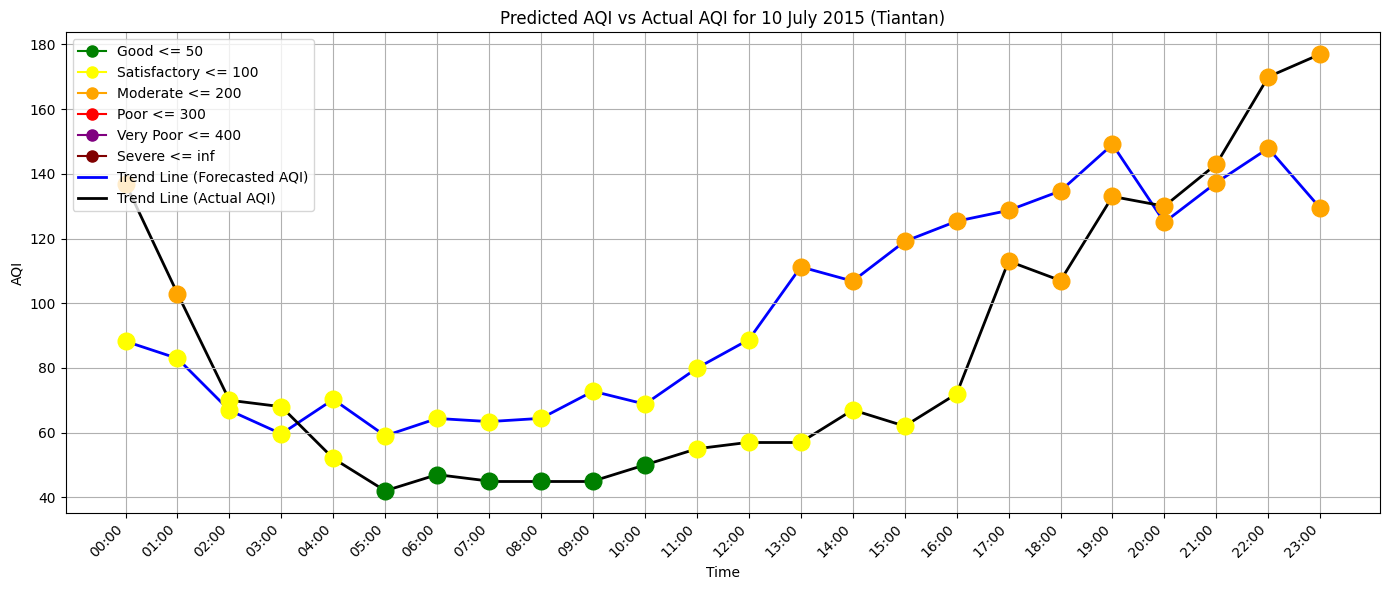

In [9]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import numpy as np

# Specify the forecast date in the desired format 'YYYY-MM-DD' in range 2013-03-08 to 2017-02-21
forecast_date = '2015-07-10'

# Define your color mapping dictionary here
color_mapping = {
    'Good': 'green',
    'Satisfactory': 'yellow',
    'Moderate': 'orange',
    'Poor': 'red',
    'Very Poor': 'purple',
    'Severe': 'maroon'
}

data = pd.read_csv(f'Preprocessed/{evaluate_station_name}_preprocessed.csv', parse_dates=True, index_col='date')
scaler_y = MinMaxScaler()
scaler_y.fit(data[output_column].values.reshape(-1, 1))

# Convert forecast_date to a datetime object
forecast_datetime = pd.to_datetime(forecast_date)

# Calculate the forecast index based on the forecast date using the same formula as Code 1
forecast_index = (forecast_datetime - data.index[0]).days

# Check if the forecast_index is within a valid range
if forecast_index < 0 or forecast_index >= len(data):
    print("Error: Invalid forecast_date specified.")
else:
    # Inverse scale the predictions and true values for plotting
    y_pred_evaluate_inv = scaler_y.inverse_transform(y_pred_evaluate)
    y_evaluate_inv = scaler_y.inverse_transform(y_evaluate)

    # Generate timestamps for each hour in the forecast period
    hourly_timestamps = pd.date_range(start=forecast_datetime, periods=output_sequence_length, freq='H')

    # Get the specific date for the main title in the desired format
    specific_date = forecast_datetime.strftime('%d %B %Y')

    plt.figure(figsize=(14, 6))

    # Create lists to store handles and labels for the legend
    legend_elements = []
    # Plot each point with its corresponding color and connect with lines
    for i, (pred_aqi, actual_aqi) in enumerate(zip(y_pred_evaluate_inv[forecast_index], y_evaluate_inv[forecast_index])):
        pred_color = color_mapping[get_AQI_bucket(pred_aqi)]
        actual_color = color_mapping[get_AQI_bucket(actual_aqi)]
        plt.plot(hourly_timestamps[i], pred_aqi, marker='o', markersize=12, color=pred_color, label=f'Predicted AQI' if i == 0 else None, zorder=2)
        plt.plot(hourly_timestamps[i], actual_aqi, marker='o', markersize=12, color=actual_color, label=f'Actual AQI' if i == 0 else None, zorder=2)
        if i > 0:
            plt.plot([hourly_timestamps[i - 1], hourly_timestamps[i]], [y_pred_evaluate_inv[forecast_index][i - 1], pred_aqi], color='blue', linestyle='-', linewidth=2, zorder=1, label='Trend Line (Forecasted AQI)')
            plt.plot([hourly_timestamps[i - 1], hourly_timestamps[i]], [y_evaluate_inv[forecast_index][i - 1], actual_aqi], color='black', linestyle='-', linewidth=2, zorder=1, label='Trend Line (Actual AQI)')

    # Add handles for the legend with color explanations
    for category, color in color_mapping.items():
        label = f'{category} <= {get_category_upper_limit(category)}'
        legend_elements.append(plt.Line2D([0], [0], marker='o', markersize=8, color=color, label=label))

    # Add handles for the legend with trendline explanations
    legend_elements.append(plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=2, label='Trend Line (Forecasted AQI)'))
    legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Trend Line (Actual AQI)'))

    plt.xlabel('Time')
    plt.ylabel('AQI')
    plt.title(f'Predicted AQI vs Actual AQI for {specific_date} ({evaluate_station_name})')

    # Set x-axis ticks to display hours only
    plt.xticks(hourly_timestamps, [ts.strftime('%H:%M') for ts in hourly_timestamps], rotation=45, ha='right')

    plt.legend(handles=legend_elements, loc='upper left')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Exploring Full Range of Forecasts vs. Actual Data

In this section, we will visualize the full range of forecasted AQI (Air Quality Index) values against the actual AQI values for a specific station. The plots will provide an overall view of how well the advanced LSTM model's predictions align with the actual data across the entire forecasted period.

## Visualization Code

Below is the Python code that generates the visualizations:

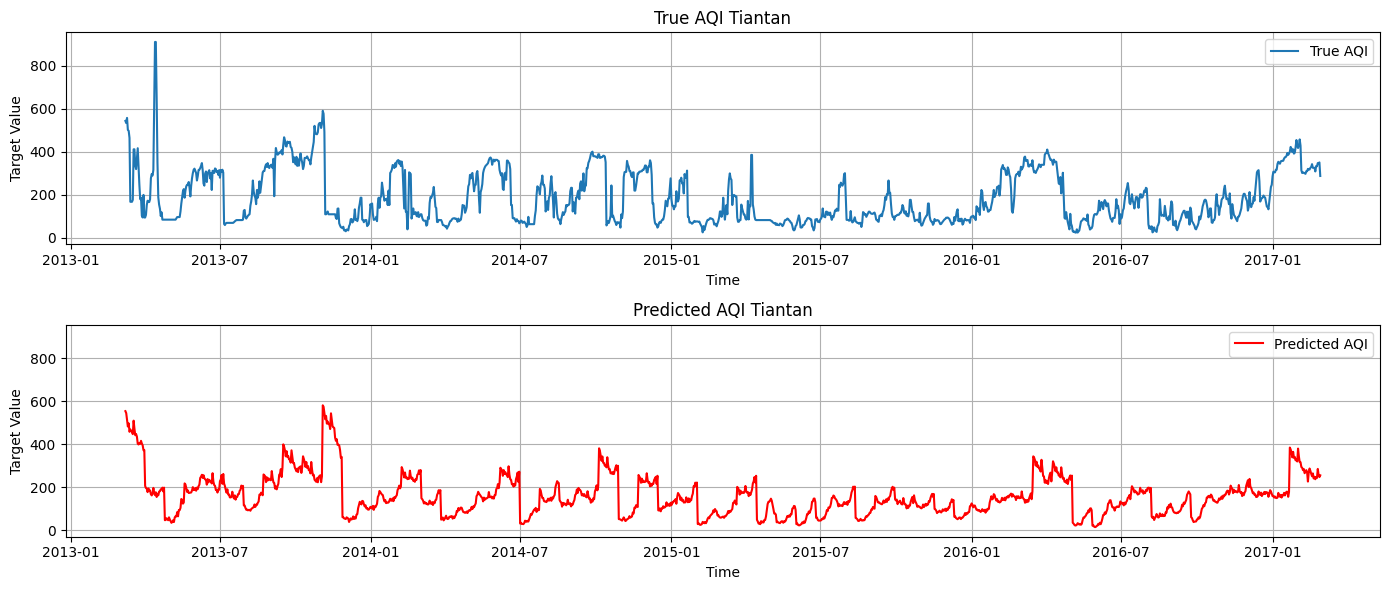

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Flatten the y_evaluate and y_pred_evaluate arrays
y_evaluate_flat = y_evaluate_inv.flatten()
y_pred_evaluate_flat = y_pred_evaluate_inv.flatten()

# Load the original DataFrame with datetime index
df = pd.read_csv(f'Preprocessed/{evaluate_station_name}_preprocessed.csv', parse_dates=True, index_col='date')

# Calculate the number of reserved sequences
num_reserved_sequences = (len(df) - input_sequence_length) // output_sequence_length

# Get the timestamps corresponding to the reserved sequences
reserved_timestamps = df.index[input_sequence_length + (np.arange(num_reserved_sequences) * output_sequence_length)]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharey=True)

# Plot y_evaluate on the first subplot
ax1.plot(reserved_timestamps, y_evaluate_flat[:len(reserved_timestamps)], label=f'True AQI')
ax1.set_xlabel('Time')
ax1.set_ylabel('Target Value')
ax1.set_title(f'True AQI {evaluate_station_name}')
ax1.grid(True)
ax1.legend()

# Plot y_pred_evaluate on the second subplot
ax2.plot(reserved_timestamps, y_pred_evaluate_flat[:len(reserved_timestamps)], label=f'Predicted AQI', color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Target Value')
ax2.set_title(f'Predicted AQI {evaluate_station_name}')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


# Generating Forecasts for Every Station

In this section, we will generate forecasts for the Air Quality Index (AQI) for each station using the trained LSTM model. These forecasts will provide predictions of AQI values for each station's future time periods.
## Forecasting Code
Below is the Python code that generates the forecasts for each station:

In [11]:
# Create a dictionary to store the predicted y values for each station
y_pred_dict = {}

# Iterate through each station in sequences_dict
for station_name in sequences_dict.keys():
    if station_name.startswith('X_'):
        # Get the corresponding y key for this station
        y_key = f'y_pred_{station_name[2:]}'
        
        # Get X and y sequences for the station
        X = sequences_dict[station_name]
        
        # Predict y_pred for the station using the loaded model
        y_pred = model.predict(X)
        
        # Store y_pred in the dictionary
        y_pred_dict[y_key] = y_pred
        
        # Print a message indicating y_pred has been created
        print(f'{y_key} created')


46/46 [==============================] - 2s 53ms/step
y_pred_Gucheng created
46/46 [==============================] - 2s 53ms/step
y_pred_Huairou created
46/46 [==============================] - 2s 52ms/step
y_pred_Tiantan created
46/46 [==============================] - 2s 52ms/step
y_pred_Changping created
46/46 [==============================] - 3s 61ms/step
y_pred_Guanyuan created
46/46 [==============================] - 2s 52ms/step
y_pred_Nongzhanguan created
46/46 [==============================] - 2s 53ms/step
y_pred_Wanliu created
46/46 [==============================] - 2s 52ms/step
y_pred_Dongsi created
46/46 [==============================] - 2s 50ms/step
y_pred_Wanshouxigong created
46/46 [==============================] - 2s 52ms/step
y_pred_Aotizhongxin created
46/46 [==============================] - 3s 57ms/step
y_pred_Dingling created
46/46 [==============================] - 3s 58ms/step
y_pred_Shunyi created


# Generating Multi-Station Forecasts for a Specific Date

In this section, we will demonstrate how to generate multi-station forecasts for a specific date using the trained LSTM model. The forecasts will provide predicted Air Quality Index (AQI) values for each station, allowing for a comprehensive overview of air quality conditions on the chosen date.
## Forecast Generation Code

Below is the Python code that generates multi-station forecasts for a specified date:

In [13]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler

# Specify the forecast date in the desired format 'YYYY-MM-DD' in range 2013-03-08 to 2017-02-21
forecast_date = '2015-07-10'

# Define sequence length (24*7=168 timesteps for inputs and 24 timesteps for output)
input_sequence_length = 24 * 7
output_sequence_length = 24

# Load data and preprocess
data = pd.read_csv(f'Preprocessed/{evaluate_station_name}_preprocessed.csv', parse_dates=True, index_col='date')
scaler_y = MinMaxScaler()
scaler_y.fit(data[output_column].values.reshape(-1, 1))

# Convert forecast_date to a datetime object
forecast_datetime = pd.to_datetime(forecast_date)

# Calculate the forecast index based on the forecast date using the same formula as Code 1
forecast_index = (forecast_datetime - data.index[0]).days

# Check if the forecast_index is within a valid range
if forecast_index < 0 or forecast_index >= len(data):
    print("Error: Invalid forecast_date specified.")
else:
    # Calculate the timestamps for the fixed columns (00:00 - 23:00) using the forecast_index
    timestamps = data.index[forecast_index * output_sequence_length: forecast_index * output_sequence_length + output_sequence_length]

    # Create a table with station name and AQI values
    table_data = [['Station Name'] + [timestamp.strftime('%H:%M') for timestamp in timestamps]]

    # Iterate through each station in y_pred_dict and add AQI values to the table
    for y_key, y_pred in y_pred_dict.items():
        station_name = y_key.split('_')[2]  # Extract station name from y_key
        y_pred_inv = scaler_y.inverse_transform(y_pred)

        # Find the index corresponding to the forecast date and select AQI values for the fixed columns
        aqi_values = [int(round(aqi)) for aqi in y_pred_inv[forecast_index, :]]

        table_data.append([station_name] + aqi_values)

    # Format the table using the tabulate library
    table_str = tabulate(table_data, headers='firstrow', tablefmt='grid')

    # Get the specific date for printing
    specific_date = forecast_datetime.strftime('%d %B %Y')
    
    if "Error" in table_str:
        print(table_str)  # Print the error message
    else:
        print(f"Forecast Date: {specific_date}")
        print(table_str)


Forecast Date: 10 July 2015
+----------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
| Station Name   |   00:00 |   01:00 |   02:00 |   03:00 |   04:00 |   05:00 |   06:00 |   07:00 |   08:00 |   09:00 |   10:00 |   11:00 |   12:00 |   13:00 |   14:00 |   15:00 |   16:00 |   17:00 |   18:00 |   19:00 |   20:00 |   21:00 |   22:00 |   23:00 |
+================+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+
| Gucheng        |      82 |      81 |      67 |      65 |      68 |      67 |      73 |      72 |      70 |      81 |      81 |      89 |     102 |     123 |     123 |     134 |     135 |     14

# Visualizing Categorical AQI Forecasts

In this section, we will enhance the AQI forecasts by visualizing the predictions in categorical terms using color-coded output. This approach provides a clear and intuitive representation of air quality conditions across multiple stations for a specific date.
## Forecast Visualization Code

Below is the Python code that visualizes AQI forecasts in categorical terms:

In [14]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler

# Specify the forecast date in the desired format 'YYYY-MM-DD' in range 2013-03-08 to 2017-02-21
forecast_date = '2015-07-10'

# Define sequence length (24*7=168 timesteps for inputs and 24 timesteps for output)
input_sequence_length = 24 * 7
output_sequence_length = 24

# Load data and preprocess
data = pd.read_csv(f'Preprocessed/{evaluate_station_name}_preprocessed.csv', parse_dates=True, index_col='date')
scaler_y = MinMaxScaler()
scaler_y.fit(data[output_column].values.reshape(-1, 1))

# Convert forecast_date to a datetime object
forecast_datetime = pd.to_datetime(forecast_date)

# Calculate the forecast index based on the forecast date using the same formula as Code 1
forecast_index = (forecast_datetime - data.index[0]).days

# Check if the forecast_index is within a valid range
if forecast_index < 0 or forecast_index >= len(data):
    print("Error: Invalid forecast_date specified.")
else:
    # Calculate the timestamps for the fixed columns (00:00 - 23:00) using the forecast_index
    timestamps = data.index[forecast_index * output_sequence_length: forecast_index * output_sequence_length + output_sequence_length]

    # Create a table with station name and AQI values
    table_data = [['Station Name'] + [timestamp.strftime('%H:%M') for timestamp in timestamps]]

    # Define a color mapping for AQI categories
    color_mapping = {
        'Good': '\033[32m',          # Green
        'Satisfactory': '\033[33m',  # Yellow
        'Moderate': '\033[31m',      # Red
        'Poor': '\033[35m',          # Purple
        'Very Poor': '\033[35m',     # Purple
        'Severe': '\033[31m'         # Red
    }

    # Iterate through each station in y_pred_dict and add AQI category values to the table
    for y_key, y_pred in y_pred_dict.items():
        station_name = y_key.split('_')[2]  # Extract station name from y_key
        y_pred_inv = scaler_y.inverse_transform(y_pred)

        # Find the index corresponding to the forecast date and select AQI category values for the fixed columns
        aqi_categories = [get_AQI_bucket(aqi) for aqi in y_pred_inv[forecast_index, :]]

        # Apply color mapping and ANSI color codes to AQI values
        color_aqi_categories = [f"{color_mapping[aqi]}{aqi}\033[0m" for aqi in aqi_categories]

        table_data.append([station_name] + color_aqi_categories)

    # Format the table using the tabulate library
    table_str = tabulate(table_data, headers='firstrow', tablefmt='grid')

    # Get the specific date for printing
    specific_date = forecast_datetime.strftime('%d %B %Y')
    
    if "Error" in table_str:
        print(table_str)  # Print the error message
    else:
        print(f"Forecast Date: {specific_date}")
        print(table_str)


Forecast Date: 10 July 2015
+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Station Name   | 00:00        | 01:00        | 02:00        | 03:00        | 04:00        | 05:00        | 06:00        | 07:00        | 08:00        | 09:00        | 10:00        | 11:00        | 12:00        | 13:00        | 14:00        | 15:00        | 16:00        | 17:00        | 18:00        | 19:00        | 20:00        | 21:00        | 22:00        | 23:00        |
+================+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+=

## Map of Beijing with the meteorological stations' locations ##

In [15]:
import folium
import pandas as pd
from IPython.display import display

In [16]:
stations_data = pd.read_csv("stations_location.csv")
stations_data

,station,location,longitude,latitude,elevation_m
0,Gucheng,Shijingshan Environmental Protection Bureau (I...,116.184,39.914,71
1,Huairou,Urban Area of Huairou (Block in town),116.628,40.328,52
2,Tiantan,Inside Temple of Heaven Park (Park in urban),116.407,39.886,33
3,Changping,Urban Area of Changping (Block in town),116.230,40.217,74
4,Guanyuan,Beijing Municipal Party School (School in urban),116.339,39.929,47
5,Nongzhanguan,Residential Area of Agricultural Exhibition Ha...,116.461,39.937,43
6,Wanliu,Inside Changchun Fitness Park (Park in urban),116.287,39.987,44
7,Dongsi,Dongcheng District Environmental Protection Bu...,116.417,39.929,31
8,Wanshouxigong,Inside Wanshou Park (Park in urban),116.352,39.878,51
9,Aotizhongxin,Inside Olympic Center (Sports Center in urban),116.397,39.982,42


In [17]:
# Create a map centered on Beijing
beijing_map = folium.Map(location=[39.9042, 116.4074], zoom_start=11)

# Plot the meteorological stations on the map
for index, station in stations_data.iterrows():
    popup_text = f"Station: {station['station']}"
    marker = folium.Marker(
        location=[station["latitude"], station["longitude"]],
        popup=popup_text,
        icon=folium.Icon(icon="cloud"),
    )
    marker.add_to(beijing_map)
    folium.map.Marker(
        location=[station["latitude"], station["longitude"]],
        icon=folium.DivIcon(html=f'<div style="color: blue; font-size: 16px;">{station["station"]}</div>')
    ).add_to(beijing_map)

# Display the map
beijing_map